In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import random

In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Print working directory
print(f"Current working directory: {os.getcwd()}")

def set_seed(seed=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Device: cuda
Current working directory: /home/ubuntu/golf-pose-preprocessing


In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((160, 160*8)),  # Resize to 80x(80*8)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load datasets
data_dir = "datafolder"
train_dir = os.path.join(data_dir, "3_frames_no_bg_dropout_train")
test_dir = os.path.join(data_dir, "3_frames_no_bg_dropout_test")

# Print dataset directories
print(f"Train dataset directory: {train_dir}")
print(f"Test dataset directory: {test_dir}")

# Check if directories exist
if not os.path.exists(train_dir):
    print(f"Train directory does not exist: {train_dir}")
if not os.path.exists(test_dir):
    print(f"Test directory does not exist: {test_dir}")

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train dataset directory: datafolder/3_frames_no_bg_dropout_train
Test dataset directory: datafolder/3_frames_no_bg_dropout_test


In [4]:
# Show how many positive samples and negative samples are in the datasets
def count_samples(loader):
    pos = 0
    neg = 0
    for data, target in loader:
        pos += target.sum()
        neg += (1 - target).sum()
    return pos, neg


train_pos, train_neg = count_samples(train_loader)
test_pos, test_neg = count_samples(test_loader)

print(f"Train dataset: {train_pos} positive samples, {train_neg} negative samples")
print(f"Test dataset: {test_pos} positive samples, {test_neg} negative samples")

Train dataset: 287 positive samples, 176 negative samples
Test dataset: 72 positive samples, 44 negative samples


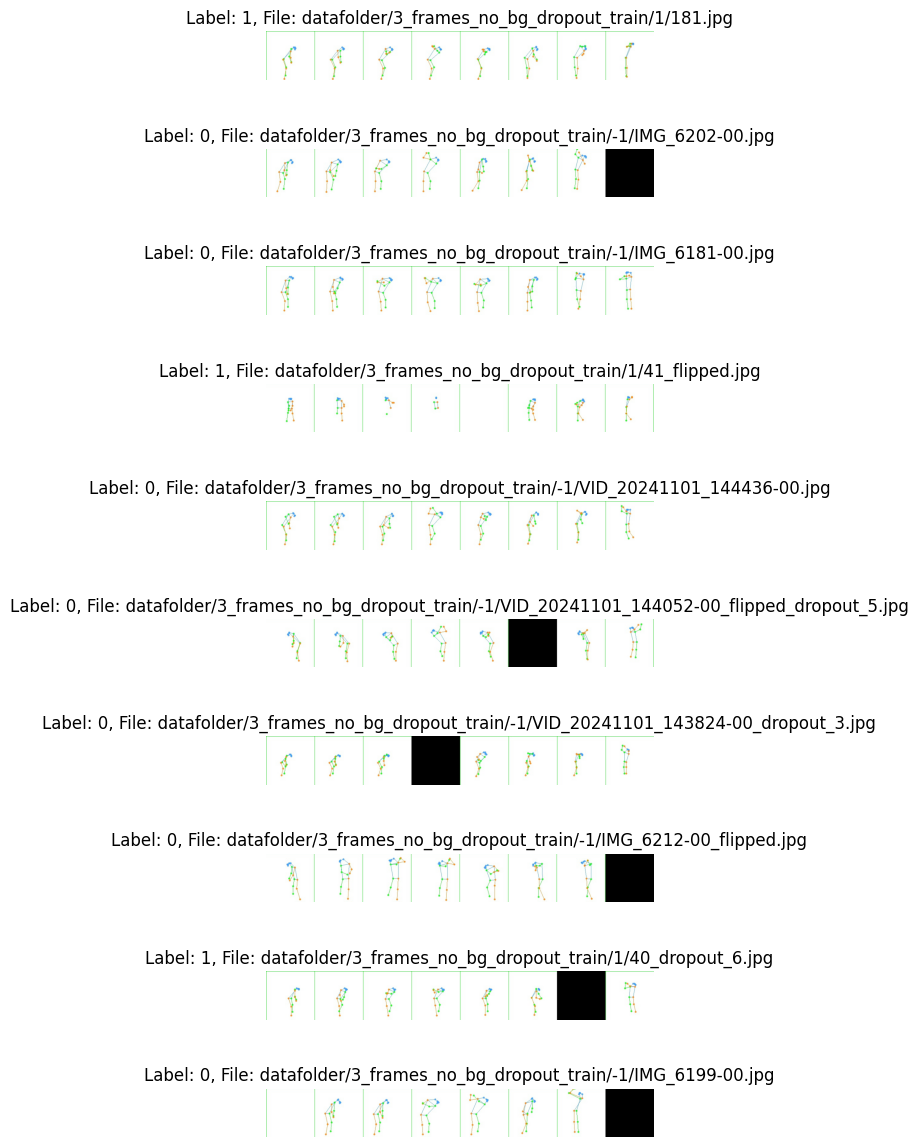

In [5]:
import matplotlib.pyplot as plt
import random

def show_sample_images(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 1, figsize=(5, 15))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # Move channel dimension to the end
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        image = image.numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}, File: {dataset.samples[idx][0]}")  # Add file name to the title
        axes[i].axis('off')
    plt.show()

# Show sample images from the training dataset
show_sample_images(train_dataset)

In [6]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, scheduler=None, num_epochs=10, writer=None):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        # Test the model
        test_acc, test_all_labels, test_all_preds = test_model(model, test_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
            f"Loss: {epoch_loss:.4f}, "
            f"Train Acc: {epoch_acc:.4f}, "
            f"Test Acc: {test_acc:.4f}")
        
        if writer:
            writer.add_scalar("Loss/train", epoch_loss, epoch)
            writer.add_scalar("Accuracy/train", epoch_acc, epoch)
            writer.add_scalar("Accuracy/test", test_acc, epoch)
            writer.flush()

        if scheduler is not None:
            scheduler.step()

    if writer:
        writer.close()

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return correct / total, all_labels, all_preds


In [ ]:
# Load pretrained ResNet
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

# # Freeze all layers in ResNet
# for param in model.parameters():
#     param.requires_grad = False

# Modify the final layer to output 2 classes (good/bad)
num_features = model.fc.in_features  # Number of features in the final layer
# model.fc = nn.Linear(num_features, 2)
model.fc = nn.Sequential(
    nn.Linear(num_features, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-5)
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},  # Larger learning rate for the new layers
    {'params': (p for name, p in model.named_parameters() if not name.startswith('fc')), 'lr': 1e-5}  # Smaller learning rate for the original layers
])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

writer = SummaryWriter("runs/golf_swing_classification")

train_model(model, train_loader, criterion, optimizer, scheduler=scheduler, num_epochs=20, writer=writer)

torch.save(model.state_dict(), "golf_swing_classification.pth")

Epoch 1/20, Loss: 0.9601, Train Acc: 0.5853, Test Acc: 0.7759
Epoch 2/20, Loss: 0.3825, Train Acc: 0.8359, Test Acc: 0.8362
Epoch 3/20, Loss: 0.2525, Train Acc: 0.9006, Test Acc: 0.9138
Epoch 4/20, Loss: 0.1721, Train Acc: 0.9287, Test Acc: 0.9397
Epoch 5/20, Loss: 0.1194, Train Acc: 0.9568, Test Acc: 0.9397
Epoch 6/20, Loss: 0.1092, Train Acc: 0.9633, Test Acc: 0.9483
Epoch 7/20, Loss: 0.0833, Train Acc: 0.9784, Test Acc: 0.9655
Epoch 8/20, Loss: 0.0621, Train Acc: 0.9870, Test Acc: 0.9397
Epoch 9/20, Loss: 0.0612, Train Acc: 0.9914, Test Acc: 0.9483
Epoch 10/20, Loss: 0.0697, Train Acc: 0.9784, Test Acc: 0.9483
Epoch 11/20, Loss: 0.0524, Train Acc: 0.9892, Test Acc: 0.9655
Epoch 12/20, Loss: 0.0466, Train Acc: 0.9957, Test Acc: 0.9569
Epoch 13/20, Loss: 0.0615, Train Acc: 0.9892, Test Acc: 0.9655
Epoch 14/20, Loss: 0.0449, Train Acc: 0.9935, Test Acc: 0.9569
Epoch 15/20, Loss: 0.0476, Train Acc: 0.9957, Test Acc: 0.9569
Epoch 16/20, Loss: 0.0498, Train Acc: 0.9892, Test Acc: 0.9569
E

In [17]:
# Test the model
test_acc, test_all_labels, test_all_preds = test_model(model, test_loader)

test_all_preds = torch.tensor(test_all_preds).unsqueeze(1)

print(f"Test Accuracy: {test_acc:.4f}")

print("Classification Report:")
print(classification_report(test_all_labels, test_all_preds, target_names=test_dataset.classes, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_all_labels, test_all_preds))

test_all_preds = test_all_preds.clone().detach().float()
if test_all_preds.dim() == 2:
    test_all_preds = test_all_preds.squeeze()

# # print the shape of the test_all_preds tensor
# print(test_all_preds.shape)

scores = torch.zeros((len(test_all_preds), 2), dtype=torch.float32)  # [batch_size, 2]
scores[:, 0] = 1.0 - test_all_preds  # probability of class 0
scores[:, 1] = test_all_preds  # probability of class 1

prob_outputs = torch.softmax(scores, dim=1)[:, 1]
auc = roc_auc_score(test_all_labels, prob_outputs)
print(f"ROC-AUC Score: {auc:.4f}")

Test Accuracy: 0.9655
Classification Report:
              precision    recall  f1-score   support

          -1     0.9348    0.9773    0.9556        44
           1     0.9857    0.9583    0.9718        72

    accuracy                         0.9655       116
   macro avg     0.9602    0.9678    0.9637       116
weighted avg     0.9664    0.9655    0.9657       116

Confusion Matrix:
[[43  1]
 [ 3 69]]
ROC-AUC Score: 0.9678


In [6]:
EVENT_NAMES = {
    0: 'Address',
    1: 'Toe-up',
    2: 'Mid-backswing-1',
    3: 'Top',
    4: 'Mid-downswing-2',
    5: 'Impact',
    6: 'Mid-follow-through',
    7: 'Finish'
}

def create_detailed_image_grid(images, 
                                row_labels=None, 
                                col_labels=None, 
                                figsize=(20, 5), 
                                spacing=0.1, 
                                title=None, 
                                filename=None):
    """
    Create a detailed image grid with row and column labels.
    
    Args:
    - images: 2D list of images (rows x columns)
    - row_labels: List of labels for rows
    - col_labels: Dictionary of column labels
    - figsize: Figure size (width, height) in inches
    - spacing: Spacing between subplots
    - title: Overall figure title
    - filename: Filename to save the figure
    
    Returns:
    - matplotlib figure object
    """
    # Determine grid dimensions
    rows = len(images)
    cols = len(images[0])
    
    # Create figure with specified size and spacing
    fig, axes = plt.subplots(rows, cols, figsize=figsize, 
                              gridspec_kw={'wspace': spacing, 'hspace': spacing})
    
    # Ensure axes is always 2D array
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Default column labels
    if col_labels is None:
        col_labels = EVENT_NAMES
    
    # Plot images
    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            
            # Handle potentially missing images
            if i < len(images) and j < len(images[i]):
                img = images[i][j]
                
                # Handle different image formats
                if img.ndim == 2:  # Grayscale
                    ax.imshow(img, cmap='gray')
                elif img.shape[2] == 3:  # RGB
                    ax.imshow(img)
                elif img.shape[2] == 4:  # RGBA
                    ax.imshow(img)
                
                # Add column labels to top row
                if i == 0:
                    ax.set_title(col_labels.get(j, f'Column {j}'), fontsize=13, fontweight='bold')
                
                # Remove ticks
                ax.set_xticks([])
                ax.set_yticks([])
            
            # Add row labels to first column
            if j == 0 and row_labels:
                ax.set_ylabel(row_labels[i], rotation=90, fontsize=13, fontweight='bold')
    
    # Add overall title if specified
    if title:
        fig.suptitle(title, fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if filename provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.close(fig)  # Close the figure to free up memory
    
    # return fig

In [12]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
from matplotlib.gridspec import GridSpec

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final layer to output 2 classes (good/bad)
num_features = model.fc.in_features  # Number of features in the final layer
# model.fc = nn.Linear(num_features, 2)
model.fc = nn.Sequential(
    nn.Linear(num_features, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 2)
)

state_dict = torch.load("golf_swing_classification.pth")
model.load_state_dict(state_dict)

model = model.to(device)

model.eval()

# Generate Grad-CAM visualizations
target_layer = [model.layer4[-1]]
# target_layer = [model.layer4[1].conv2]

def generate_gradcam_visualizations(model, dataset, target_layers, device):
    cam = ScoreCAM(model=model, target_layers=target_layers)
    img_count = 0
    for image, label in dataset:
        if label == 0:
            label = -1
        image = image.to(device)
        output = model(image.unsqueeze(0))
        predicted_class = torch.argmax(output, dim=1)

        target = [ClassifierOutputTarget(predicted_class.item())]
        grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=target)

        img = image.cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        visualization = show_cam_on_image(img, grayscale_cam[0], use_rgb=True)

        # cv2.imwrite(f'resnet_hirescam_visualizations/gradcam_visualization_{img_count}.jpg', visualization)
        # Get file name
        original_file_path = dataset.samples[img_count][0]
        file_name = os.path.basename(original_file_path)
        last_folder = os.path.basename(os.path.dirname(original_file_path))
        relative_path = os.path.join(last_folder, file_name)
        new_file_path_test = os.path.join(f"datafolder/3_original_event_frames_dropout_test/", relative_path)
        new_file_path_2 = os.path.join(f"datafolder/3_frames_with_bg_dropout_test/", relative_path)


        original_img = np.zeros((160, 1280, 3))
        if os.path.exists(new_file_path_test):
            original_img = cv2.imread(new_file_path_test)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

            # print(f"Image found at: {new_file_path_test}")

        elif os.path.exists(new_file_path_2):
            original_img = cv2.imread(new_file_path_2)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            # print(f"Image found at: {new_file_path_2}")
        # else:
            # print(f"Image not found at {new_file_path_test}")

        # Split RGB and visualization into parts
        combined_images_list = [[original_img[:, :160, :], original_img[:, 160:320, :], original_img[:, 320:480, :], original_img[:, 480:640, :], original_img[:, 640:800, :], original_img[:, 800:960, :], original_img[:, 960:1120, :], original_img[:, 1120:1280, :]],
                                [visualization[:, :160, :], visualization[:, 160:320, :], visualization[:, 320:480, :], visualization[:, 480:640, :], visualization[:, 640:800, :], visualization[:, 800:960, :], visualization[:, 960:1120, :], visualization[:, 1120:1280, :]]]
        
        # Make and save detailed grid
        create_detailed_image_grid(combined_images_list, ['RGB', 'Grad-Cam'], 
                                   filename=f'resnet_scorecam_visualizations/gradcam_visualization_{img_count}.png')

        img_count += 1

generate_gradcam_visualizations(model, test_dataset, target_layer, device)

/tmp/ipykernel_14566/1485665168.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("golf_swing_classification.pth")
100%|██████████| 32/32 [00:00<0